## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, confusion_matrix, precision_recall_curve, roc_curve, average_precision_score

# Tensorflow imports
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout

## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')

all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])

all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
81742,00020111_000.png,No Finding,0,20111,26,M,PA,2992,2991,0.143,0.143,NaN,/data/images_009/images/00020111_000.png
72484,00017853_000.png,Atelectasis,0,17853,39,F,PA,3056,2516,0.139,0.139,NaN,/data/images_008/images/00017853_000.png
20892,00005574_002.png,Infiltration,2,5574,44,F,PA,2730,2961,0.143,0.143,NaN,/data/images_003/images/00005574_002.png


In [3]:
## Get the list of all diseases found
findings_df = all_xray_df['Finding Labels'].map(lambda x: x.split('|'))
findings_list = list(chain(*findings_df))
diseases = np.unique(findings_list)

print(diseases)

['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


In [4]:
## Create extra columns with binary indicators for each disease
for disease in diseases:
    all_xray_df[disease] = all_xray_df['Finding Labels'].apply(lambda x: disease in x)

In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].apply(lambda x: 'Positive' if x else 'Negative')

## Create your training and testing data:

In [6]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, val_data = train_test_split(df, test_size=0.2, stratify=df['Pneumonia'])
    return train_data, val_data

In [7]:
train_df, val_df = create_splits(all_xray_df)

### Balance datasets

In [8]:
def get_total(elem): return elem['total_samples']

def get_distribution(df):
    diseases_data = []
    total_data = len(df)
    
    for disease in diseases:
        total_samples = len(df[df[disease] == True])
        percentage = round(100 * total_samples / total_data, 2)
        diseases_data.append({
            'name': disease,
            'total_samples': total_samples,
            'percentage': percentage
        })
        
    diseases_data.sort(key=get_total, reverse=True)
    return diseases_data

def show_distribution(data, df):
    total_data = len(df)
    total_diseases = len(diseases)
    
    print(f'Total df: {total_data}')
    print(f'Total diseases: {total_diseases}\n')
    for disease in data:
        name = disease['name']
        total_samples = disease['total_samples']
        percentage = disease['percentage']
        blank = ' ' * (20 - len(name))
        complement = '<====' if name == 'Pneumonia' else ''

        print(f'{name}: {blank} {total_samples} ({percentage}%) {complement}')

In [9]:
total_data = len(train_df)
total_diseases = len(diseases)

diseases_data = get_distribution(train_df)
show_distribution(diseases_data, train_df)

Total df: 89696
Total diseases: 15

No Finding:            48374 (53.93%) 
Infiltration:          15907 (17.73%) 
Effusion:              10654 (11.88%) 
Atelectasis:           9167 (10.22%) 
Nodule:                5055 (5.64%) 
Mass:                  4587 (5.11%) 
Pneumothorax:          4286 (4.78%) 
Consolidation:         3722 (4.15%) 
Pleural_Thickening:    2705 (3.02%) 
Cardiomegaly:          2197 (2.45%) 
Emphysema:             1979 (2.21%) 
Edema:                 1844 (2.06%) 
Fibrosis:              1345 (1.5%) 
Pneumonia:             1145 (1.28%) <====
Hernia:                179 (0.2%) 


Pneumonia is the second least represented disease within the train set

In [10]:
pneumonia_percentage = 0

for disease in diseases_data:
    if disease['name'] == 'Pneumonia': 
        pneumonia_percentage = disease['percentage']

In [11]:
def determine_removal(diseases):
    # No pneumonia sample should be remove from training set
    if 'Pneumonia' in diseases: return False
    
    r = np.random.random() * 100
    return r > pneumonia_percentage

In [12]:
train_df['remove'] = train_df['Finding Labels'].apply(lambda x: determine_removal(x.split('|')))
val_df['remove'] = val_df['Finding Labels'].apply(lambda x: determine_removal(x.split('|')))

balanced_train_df = train_df[train_df['remove'] == False]
balanced_val_df = val_df[val_df['remove'] == False]

b_data = get_distribution(balanced_train_df)
show_distribution(b_data, balanced_train_df)

Total df: 2314
Total diseases: 15

Pneumonia:             1145 (49.48%) <====
Infiltration:          669 (28.91%) 
No Finding:            662 (28.61%) 
Effusion:              348 (15.04%) 
Atelectasis:           332 (14.35%) 
Edema:                 280 (12.1%) 
Consolidation:         159 (6.87%) 
Mass:                  119 (5.14%) 
Nodule:                117 (5.06%) 
Pneumothorax:          79 (3.41%) 
Pleural_Thickening:    75 (3.24%) 
Cardiomegaly:          65 (2.81%) 
Emphysema:             38 (1.64%) 
Fibrosis:              29 (1.25%) 
Hernia:                5 (0.22%) 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [13]:
def train_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    idg = ImageDataGenerator(
        rescale = 1./255,
        horizontal_flip = True,
        vertical_flip = False,
        height_shift_range = 0.1,
        width_shift_range = 0.1,
        rotation_range = 15,
        zoom_range = 0.1,
        fill_mode = 'constant',
        samplewise_center = True,
        samplewise_std_normalization = True
    )
    
    return idg


def make_gen(df, train=True):
    
    ## Create the actual generators using the output of my_image_augmentation for your data
    
    data_gen = train_image_augmentation().flow_from_dataframe(
        dataframe=df, 
        directory=None, 
        x_col = 'path',
        y_col = 'pneumonia_class',
        class_mode = 'binary',
        target_size = (224, 224), 
        batch_size = 32,
        shuffle = train
    )

    return data_gen

In [14]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_gen(balanced_val_df, train=False)
valX, valY = val_gen.next()

Found 550 validated image filenames belonging to 2 classes.


Found 2314 validated image filenames belonging to 2 classes.


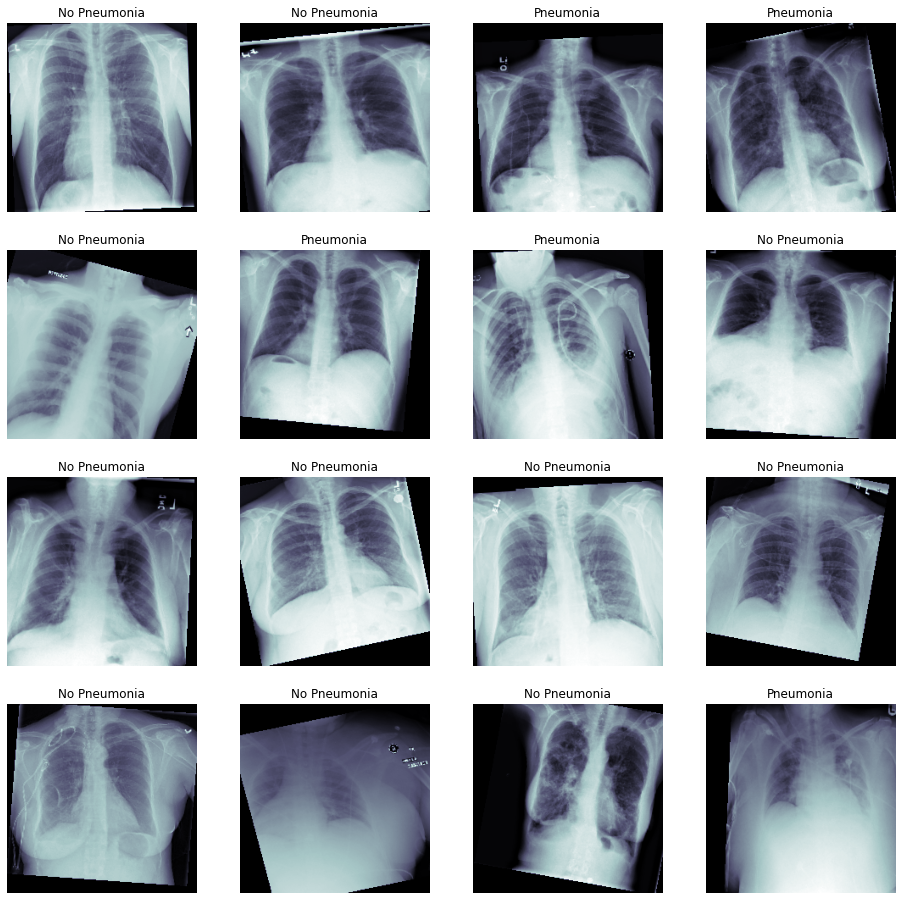

In [15]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
train_gen = make_gen(balanced_train_df)

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [16]:
model = VGG16(include_top=True, weights='imagenet', input_shape=(224, 224, 3))
model.summary()

553467904/553467096 [==============================] - 17s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [17]:
def load_pretrained_model(layer_of_interest):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(layer_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Freeze VGG layers for training
    for layer in vgg_model.layers:
        layer.trainable = False
    
    return vgg_model


In [18]:
def build_model(lr=1e-3):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    model = Sequential()
    
    model.add(load_pretrained_model('flatten'))
    
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    # Optimizer
    optimizer = Adam(learning_rate=lr)
    loss = 'binary_crossentropy'
    
    # Compite model
    model.compile(optimizer=optimizer, loss=loss, metrics=['binary_accuracy'])
    
    return model


## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [19]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')
monitor = 'val_loss'
mode = 'min'

checkpoint = ModelCheckpoint(
    weight_path,
    monitor = monitor,
    verbose = 1,
    save_best_only = True,
    mode = mode,
    save_weights_only = True
)

early = EarlyStopping(
    monitor = monitor, 
    mode = mode, 
    patience = 10
)

callbacks_list = [checkpoint, early]

In [20]:
## Hyperparameters
epochs = 10
lr = 7e-4

model = build_model(lr=lr)

### Start training! 

In [21]:
history = model.fit_generator(
    train_gen, 
    validation_data = (valX, valY), 
    epochs = epochs, 
    callbacks = callbacks_list
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 73 steps, validate on 32 samples
Epoch 1/10
72/73 [============================>.] - ETA: 0s - loss: 1.2011 - binary_accuracy: 0.5403
Epoch 00001: val_loss improved from inf to 0.71309, saving model to xray_class_my_model.best.hdf5
73/73 [==============================] - 69s 952ms/step - loss: 1.1934 - binary_accuracy: 0.5419 - val_loss: 0.7131 - val_binary_accuracy: 0.5625
Epoch 2/10
72/73 [============================>.] - ETA: 0s - loss: 0.7086 - binary_accuracy: 0.5811
Epoch 00002: val_loss improved from 0.71309 to 0.67116, saving model to xray_class_my_model.best.hdf5
73/73 [==============================] - 62s 844ms/step - loss: 0.7091 - binary_accuracy: 0.5799 - val_loss: 0.6712 - val_binary_accuracy: 0.5000
Epoch 3/10
72/73 [============================>.] - ETA: 0s - loss: 0.6729 - binary_accuracy: 0.5929
Epoch 00003: val_loss did not improve from 0.67116
73/73 [===

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [22]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights(weight_path)
pred_Y = model.predict(valX, batch_size = 32, verbose = True)


32/32 [==============================] - 0s 13ms/sample


In [40]:
def plot_history(history):
    epochs_range = range(len(history['loss']))
    metrics = ['binary_accuracy', 'loss']
    index = 121
    plt.figure(figsize=(20, 5))
    
    for metric in metrics:
        plt.subplot(index)
        plt.plot(epochs_range, history[metric], label='Train')
        plt.plot(epochs_range, history[f'val_{metric}'], label='Val')
        plt.legend()
        plt.title(metric)
        
        index += 1

def plot_metrics(y_true, y_pred):
    # Create figure
    plt.figure(figsize=(20, 15))
    
    # False Positive and True Positive rates
    fp_rate, tp_rate, _ = roc_curve(y_true, y_pred)
    
    # Precision, recall and threshold
    precision, recall, threshold = precision_recall_curve(y_true, y_pred)
    threshold = np.append(threshold, 1.0)
    # Average precision and ROC curve
    avg_precision = round(average_precision_score(y_true, y_pred), 5)
    roc_auc = round(auc(fp_rate, tp_rate), 5)
    # F1 Score
    epsilon = 1e-5
    f1_score = 2 * (precision * recall) / (precision + recall + epsilon)
    
    # TP rate / FP rate graph
    plt.subplot(221)
    plt.plot(fp_rate, tp_rate, label=f'AUC: {roc_auc}')
    plt.legend(loc=4, fontsize=12)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('TP Rate vs FP Rate', fontsize=16)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Precision / Recall graph
    plt.subplot(222)
    plt.plot(recall, precision, label=f'Av Precision: {avg_precision}')
    plt.legend(loc=3, fontsize=12)
    plt.title('Precision vs Recall', fontsize=16)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # F1 / Threshold graph
    plt.subplot(223)
    plt.plot(threshold, f1_score)
    plt.title('F1 vs Threshold', fontsize=16)
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    
    # Show results
    plt.show()
    
    return f1_score, threshold
    

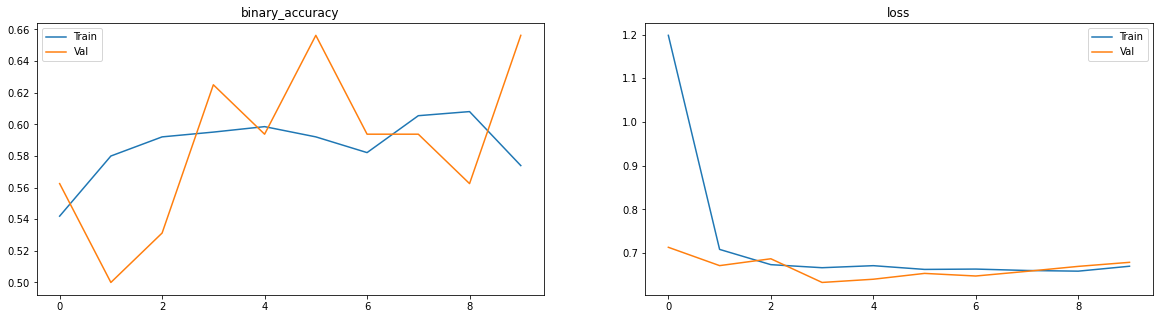

In [24]:
plot_history(history.history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [25]:
import math

val_size = len(val_gen.filenames)
val_batches = int(math.ceil(val_size / 32.0))

val_labels = []
for i in range(val_batches):
    val_labels.extend(np.array(val_gen[i][1]))

In [26]:
val_pred_Y = model.predict(val_gen, verbose=True)

18/18 [==============================] - 16s 879ms/step


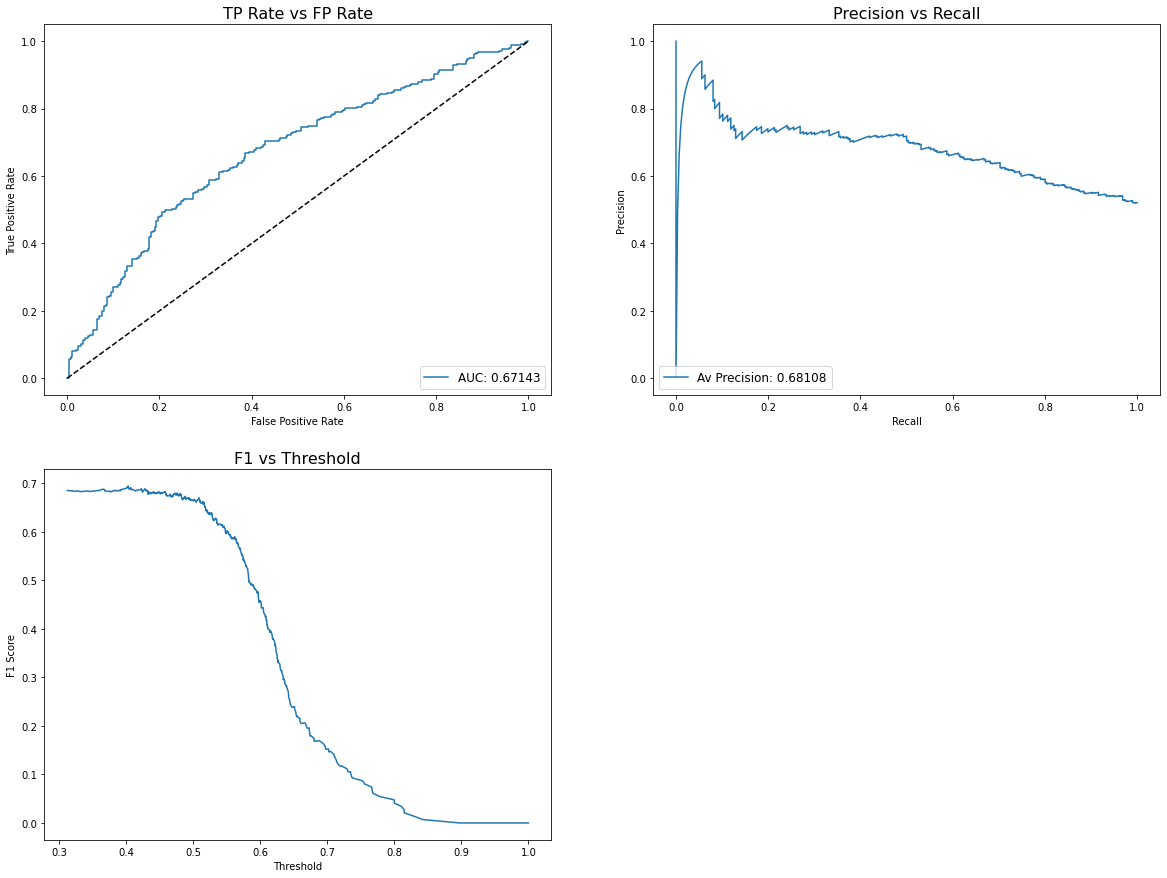

In [41]:
f1_score, threshold = plot_metrics(val_labels, val_pred_Y)

### Find threshold

In [46]:
# Get F1 Score max index
max_index = np.argmax(f1_score)
max_threshold = threshold[max_index]

print(f'Max F1 Score is {f1_score[max_index]} when the threshold is {max_threshold}')

Max F1 Score is 0.6942309900368099 when the threshold is 0.4034073054790497


In [47]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)